# AVL on-demand clusters: processing Sen-ET data

Import a few necessary packages.

In [1]:
from numpy import datetime64
from datetime import datetime
from dask.distributed import Client

Create an on-demand cluster, specifying the number of worker nodes.

In [ ]:
cluster = new_cluster(name='cluster_demo', n_workers=20)

Confirm that the cluster is running.

In [3]:
cluster.status

<Status.running: 'running'>

Show the link to the cluster’s monitoring dashboard, so that we can follow the progress of our calculations.

In [ ]:
cluster.dashboard_link

Create a dask client that uses the cluster. You can delete or comment out this cell (and the cluster-related cells above) if you want to try running the notebook without the cluster to compare the speed.

In [5]:
client = Client(cluster)

Open a Sen-ET multi-level dataset for an S2 tile over a year.

In [6]:
ds_levels = data_store.open_data('demo/EVAPOTRANSPIRATION_SENET_31UFR.levels')

Get the full-resolution dataset from the multi-level dataset.

In [7]:
ds = ds_levels.get_dataset(0)

Show the dataset’s metadata.

In [8]:
ds

<xarray.Dataset>
Dimensions:                   (time: 114, y: 5490, x: 5490)
Coordinates:
  * time                      (time) datetime64[ns] 2020-01-01 ... 2020-12-31
  * x                         (x) float32 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y                         (y) float32 5.6e+06 5.6e+06 ... 5.49e+06 5.49e+06
Data variables:
    crs                       int32 ...
    daily_evapotranspiration  (time, y, x) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes: (12/22)
    Conventions:              CF-1.7
    geospatial_bounds:        POLYGON((600000.0 5600040.0, 600000.0 5490240.0...
    geospatial_bounds_crs:    PROJCS["WGS 84 / UTM zone 31N",GEOGCS["WGS 84",...
    geospatial_lat_max:       50.54373917381065
    geospatial_lat_min:       49.52841829395487
    geospatial_lat_units:     degrees_north
    ...                       ...
    geospatial_y_units:       metre
    keywords:                 ESA, AVL, Agriculture, EO
    sources:                  ['EVAPOTRANSPIRATION_SENET_31UFR_20200101.ZARR'...
    summary:                  This dataset is used to demonstrate the AVL com...
    time_coverage_start:      2020-01-01 00:00:00
    title:                    Agricultural Virtual Laboratory Dataset

Replace the time co-ordinate values with their corresponding month numbers, and rename the co-ordinate accordingly.

In [10]:
ds['time'] = ds.time.dt.month
ds = ds.rename(dict(time='month'))
ds

<xarray.Dataset>
Dimensions:                   (month: 114, y: 5490, x: 5490)
Coordinates:
  * month                     (month) int64 1 1 1 1 1 1 1 ... 12 12 12 12 12 12
  * x                         (x) float32 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y                         (y) float32 5.6e+06 5.6e+06 ... 5.49e+06 5.49e+06
Data variables:
    crs                       int32 ...
    daily_evapotranspiration  (month, y, x) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes: (12/22)
    Conventions:              CF-1.7
    geospatial_bounds:        POLYGON((600000.0 5600040.0, 600000.0 5490240.0...
    geospatial_bounds_crs:    PROJCS["WGS 84 / UTM zone 31N",GEOGCS["WGS 84",...
    geospatial_lat_max:       50.54373917381065
    geospatial_lat_min:       49.52841829395487
    geospatial_lat_units:     degrees_north
    ...                       ...
    geospatial_y_units:       metre
    keywords:                 ESA, AVL, Agriculture, EO
    sources:                  ['EVAPOTRANSPIRATION_SENET_31UFR_20200101.ZARR'...
    summary:                  This dataset is used to demonstrate the AVL com...
    time_coverage_start:      2020-01-01 00:00:00
    title:                    Agricultural Virtual Laboratory Dataset

Create a `GroupBy` object which groups the dataset’s values by month number.

In [11]:
gb = ds.groupby('month')
gb

DatasetGroupBy, grouped over 'month'
10 groups with labels 1, 2, 5, 6, 7, 8, 9, 10, 11, 12.

Take the mean over each month – this operation will complete very quickly, since the calculation is not actually performed until the results are needed.

In [12]:
means = gb.mean()
means

<xarray.Dataset>
Dimensions:                   (month: 10, y: 5490, x: 5490)
Coordinates:
  * x                         (x) float32 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y                         (y) float32 5.6e+06 5.6e+06 ... 5.49e+06 5.49e+06
  * month                     (month) int64 1 2 5 6 7 8 9 10 11 12
Data variables:
    crs                       (month) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    daily_evapotranspiration  (month, y, x) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes: (12/22)
    Conventions:              CF-1.7
    geospatial_bounds:        POLYGON((600000.0 5600040.0, 600000.0 5490240.0...
    geospatial_bounds_crs:    PROJCS["WGS 84 / UTM zone 31N",GEOGCS["WGS 84",...
    geospatial_lat_max:       50.54373917381065
    geospatial_lat_min:       49.52841829395487
    geospatial_lat_units:     degrees_north
    ...                       ...
    geospatial_y_units:       metre
    keywords:                 ESA, AVL, Agriculture, EO
    sources:                  ['EVAPOTRANSPIRATION_SENET_31UFR_20200101.ZARR'...
    summary:                  This dataset is used to demonstrate the AVL com...
    time_coverage_start:      2020-01-01 00:00:00
    title:                    Agricultural Virtual Laboratory Dataset

Create a facet plot showing the mean daily evapotranspiration for each month. This is the time-consuming step: creating the plot requires the actual data so it triggers the required calculations. If you’re running this notebook with a cluster, you can use the dashboard link (shown above) to open the cluster dashboard in another window and see how the computation task is being distributed among the cluster worker nodes. We use JupyterLab’s [time magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-time) to show how long the whole operation takes.

CPU times: user 10.3 s, sys: 3.59 s, total: 13.9 s
Wall time: 59.2 s


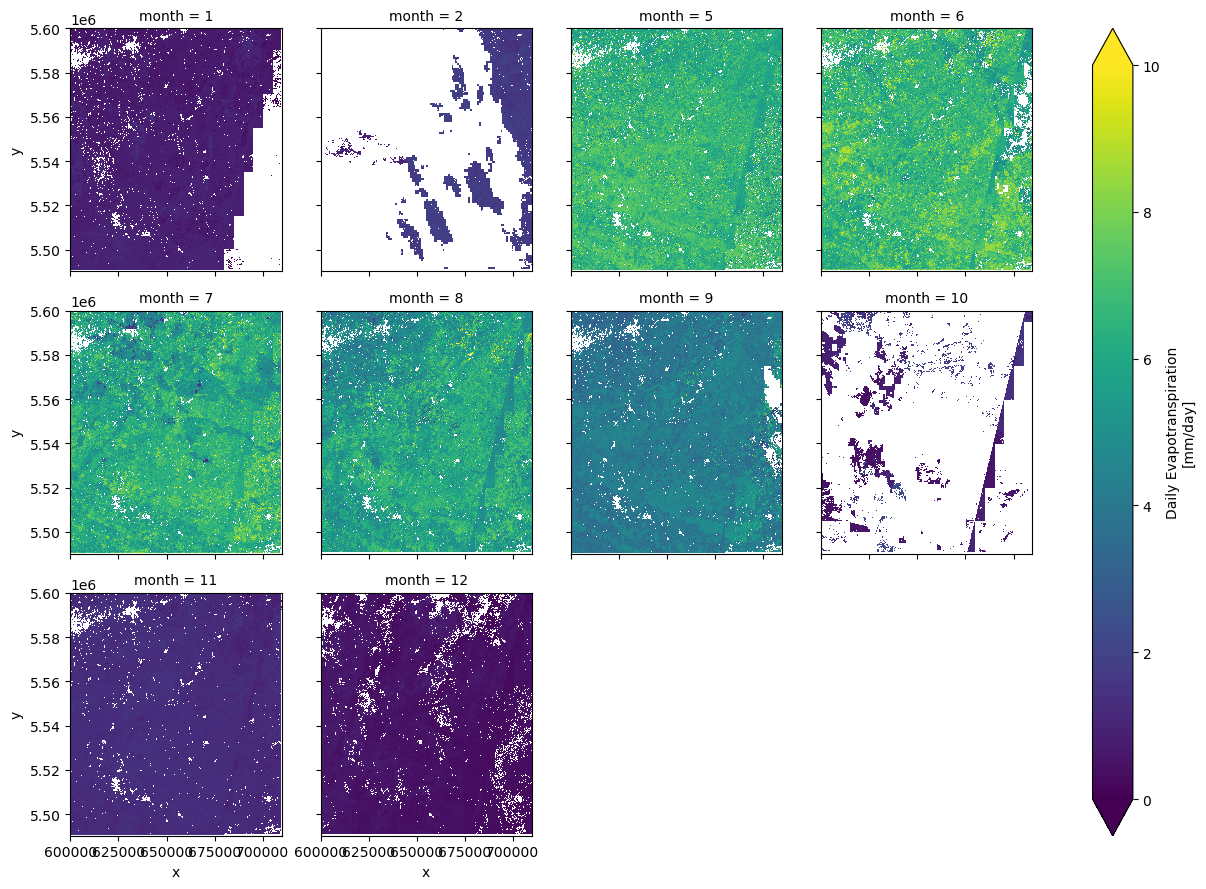

In [13]:
%%time
means.daily_evapotranspiration.plot.imshow(col='month', col_wrap=4, vmin=0, vmax=10)

Close the cluster. An unused cluster will eventually be shut down automatically, but it’s good practice to do it explicitly to save resources when we know we won’t be needing it again.

In [14]:
cluster.close()